# Create NLDI Site JSON
Date Updated: 08/22/2022

Steps to be taken...
- read in input files (created with SQL queries)
- clean & processes the Data...
- match the NLDI schema
- convert to geojson
- export outputs

In [1]:
# Needed Libararies

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt

pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Setting work directory

cwd = os.getcwd()
Output = cwd
print("current directory = "+Output)

current directory = C:\Users\rjame\Documents\WSWC Documents\WaDE-Side-Projects\NLDI Sites for WestDAAT


## Input Data
- organizations
- sites

In [3]:
# organization input data and dataframe creation

fileInput = "rawdata/organization_raw.csv"
dforg = pd.read_csv(fileInput).replace(np.nan, "")
print(len(dforg))
dforg.head(1)

17


,State,OrganizationUUID
0,AZ,AZwr_O1


In [4]:
# Sites input data and dataframe creation

fileInput = "rawdata/sites_raw.zip"
df = pd.read_csv(fileInput).replace(np.nan, "")
print(len(df))
df.head(1)

2486525


,SiteUUID,Latitude,Longitude
0,AZwr_SPODA01001001BAB,33.464822,-112.215312


## Clean & Processes the Data

In [5]:
# ensure lat and long values are numeric.  If not / if NaN, drop data.

# Temp fix
# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

df = df[(df['Latitude'].astype(int) > 10) & (df['Latitude'].astype(int) < 50)]
df = df[(df['Longitude'].astype(int) < 0) & (df['Longitude'].astype(int) > -125)]

print(len(df))
df.head(1)

2486525


,SiteUUID,Latitude,Longitude
0,AZwr_SPODA01001001BAB,33.464822,-112.215312


In [6]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

df['State'] = df.apply(lambda row: createState(row['SiteUUID']), axis=1)
df['State'].unique()

array(['AZ', 'CA', 'CO', 'ID', 'KS', 'MT', 'ND', 'NE', 'NM', 'NV', 'OK',
       'OR', 'SD', 'TX', 'UT', 'WA', 'WY'], dtype=object)

In [7]:
# Left-Join Organization info

df = df.merge(dforg, on='State', how='left')
print(len(df))
df.head(1)

2486525


,SiteUUID,Latitude,Longitude,State,OrganizationUUID
0,AZwr_SPODA01001001BAB,33.464822,-112.215312,AZ,AZwr_O1


In [8]:
# add custom NLDI fields

df['GeoconnexAddress'] = "https://geoconnex.us/wade/sites/" + df['SiteUUID'].astype(str)
df['WaDELandingPageLink'] = "https://westdaat.westernstateswater.org/details/site/" + df['SiteUUID'].astype(str)
print(len(df))
df.head()

2486525


,SiteUUID,Latitude,Longitude,State,OrganizationUUID,GeoconnexAddress,WaDELandingPageLink
0,AZwr_SPODA01001001BAB,33.464822,-112.215312,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,https://westdaat.westernstateswater.org/detail...
1,AZwr_SPODA01001001BCB,33.461270,-112.219719,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,https://westdaat.westernstateswater.org/detail...
2,AZwr_SPODA01001001BDC,33.459536,-112.215384,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,https://westdaat.westernstateswater.org/detail...
3,AZwr_SPODA01001001CAA,33.457780,-112.213228,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,https://westdaat.westernstateswater.org/detail...
4,AZwr_SPODA01001001CBB,33.457779,-112.219776,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,https://westdaat.westernstateswater.org/detail...


<!-- ## Convert to geojson -->

## Match NLDI Schema
- match this sample 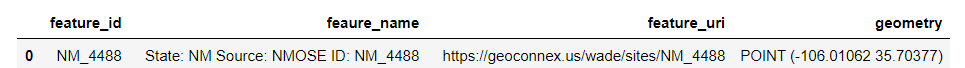

In [9]:
# create new dataframe.  match schmea from NLDI.
df2 = pd.DataFrame(columns=['feature_id', 'feature_name', 'feature_uri'], index=df.index)

df2['feature_id'] = df['SiteUUID']
df2['feature_name'] = "State: " + df['State'].astype(str) + " Source: " + df['OrganizationUUID'].astype(str) + " ID: " + df['SiteUUID'].astype(str)
df2['feature_uri'] = df['GeoconnexAddress']

print(len(df2))
df2.head()

2486525


,feature_id,feature_name,feature_uri
0,AZwr_SPODA01001001BAB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...
1,AZwr_SPODA01001001BCB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...
2,AZwr_SPODA01001001BDC,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...
3,AZwr_SPODA01001001CAA,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...
4,AZwr_SPODA01001001CBB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...


In [10]:
# convert dataframe to geodataframe

gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
print(len(gdf2))
gdf2.head()

2486525


,feature_id,feature_name,feature_uri,geometry
0,AZwr_SPODA01001001BAB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,POINT (-112.21531 33.46482)
1,AZwr_SPODA01001001BCB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,POINT (-112.21972 33.46127)
2,AZwr_SPODA01001001BDC,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,POINT (-112.21538 33.45954)
3,AZwr_SPODA01001001CAA,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,POINT (-112.21323 33.45778)
4,AZwr_SPODA01001001CBB,State: AZ Source: AZwr_O1 ID: AZwr_SPODA010010...,https://geoconnex.us/wade/sites/AZwr_SPODA0100...,POINT (-112.21978 33.45778)


## Check & Examine the resuling Data
- plot it out, look for oddities.

<AxesSubplot: >

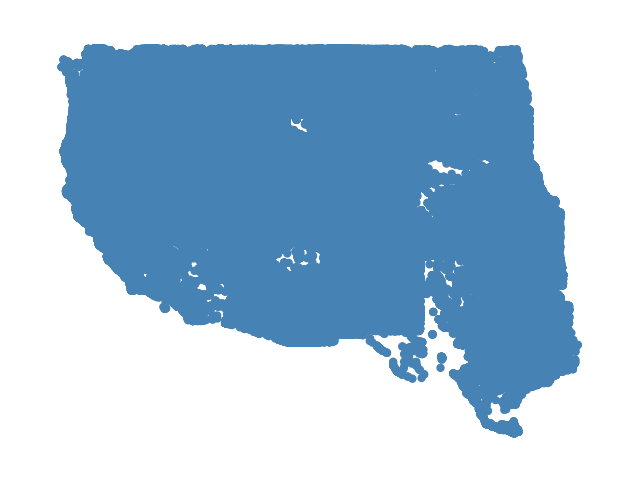

In [11]:
gplt.pointplot(gdf2)

## Exporting Files
- be sure to save the results on this google drive: https://drive.google.com/drive/folders/1JKDaSUcfao4BgvCFFT5B_OY6aGbWTI9e

In [12]:
# export geodataframe as geojson
# compress to zip file by hand
df2.to_csv('outputs/wadeNLDISites.csv', index=False)
gdf2.to_file("outputs/wade.geojson", driver='GeoJSON')